In [100]:
import os
import torch
import math
print(f"PyTorch has version {torch.__version__} with cuda {torch.version.cuda}")

PyTorch has version 2.3.1+cpu with cuda None


In [101]:
#!pip install torch_geometric

# Optional dependencies:
#!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cu121.html

In [102]:
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing, radius_graph
from torch_geometric.utils import add_self_loops
import torch_cluster
import torch_scatter
print(f"PyTorch has version {torch.__version__} with cuda {torch.version.cuda}")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PyTorch has version 2.3.1+cpu with cuda None


In [103]:
print(np.__version__)

1.26.4


In [104]:
# start coding with numpy==1.23.1
# !pip uninstall numpy -y
# !pip install numpy==1.23.1

In [105]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch_geometric.data import Data
from torch_geometric.nn import radius_graph
from torch_geometric.utils import add_self_loops
from torch_geometric.utils import to_networkx
import networkx as nx

First, create a function to generate a graph from raw data.

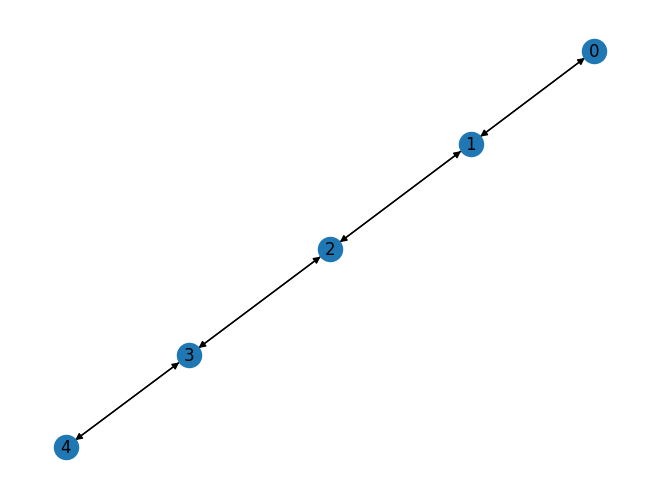

tensor([[ 1.0000, -1.0000,  0.0000,  3.1588],
        [ 1.0000,  1.0000,  0.0000,  8.1799],
        [ 1.0000, -1.0000,  0.0000,  3.4436],
        [ 1.0000,  1.0000,  0.0000,  6.5237],
        [ 1.0000, -1.0000,  0.0000,  0.0742],
        [ 1.0000,  1.0000,  0.0000,  8.4119],
        [ 1.0000, -1.0000,  0.0000,  8.7599],
        [ 1.0000,  1.0000,  0.0000,  4.4479]])


In [106]:


def create_gnn_graph(coordinates, metadata):
    """
    Create a graph data object for a GNN model.

    Args:
    - coordinates (list of tuples): A list of 2D coordinates for each node.
    - E_initial (float): The initial value for the edge attribute.

    Returns:
    - data (Data): A PyG Data object representing the graph.
    """

    # Convert coordinates to tensor
    node_features = torch.tensor(coordinates, dtype=torch.float)

    # Add the load as a node attribute
    load = torch.rand(node_features.size(0), 1) * metadata["P_initial"]
    dist_boundary = torch.norm(node_features - torch.tensor([[0, 0]], dtype=torch.float), dim=1).unsqueeze(1)

    # Create edges
    num_nodes = len(coordinates)
    edge_index = radius_graph(node_features, r=metadata["default_connectivity_radius"], loop=False)

    # Calculate edge attributes (e.g., Euclidean distance)
    distance = torch.norm(node_features[edge_index[0]] - node_features[edge_index[1]], dim=1).unsqueeze(1)
    # Calculate displacement as vector at each edge
    displacement = (node_features[edge_index[1]] - node_features[edge_index[0]])

    # Convert E_initial to a PyTorch tensor
    E_initial = torch.tensor(metadata["E_initial"], dtype=torch.float)
    # Correctly generate a tensor with random values uniformly distributed between 0 and 1, then scale by E_initial
    E_edge = torch.rand(edge_index.size(1), 1) * E_initial

    # Now, both tensors have shape [number_of_edges, 1] and can be concatenated
    edge_attr = torch.cat([distance, displacement, E_edge], dim=1)

    # Create a graph data object
    graph_data = Data(pos=node_features, edge_index=edge_index, edge_attr=edge_attr, node_attr=load)

    return graph_data

# Example usage
metadata = {"default_connectivity_radius": 1.6, "E_initial": 10, "P_initial": 0}
coordinates = [(0.5, 0), (1.5, 0), (2.5, 0), (3.5, 0), (4.5, 0)]
graph_data = create_gnn_graph(coordinates, metadata)

graph = to_networkx(graph_data)
nx.draw(graph, with_labels=True)
plt.show()

print(graph_data.edge_attr)

In [107]:
# Check version of cuda
import torch
print(torch.__version__)
print(torch.version.cuda)

2.3.1+cpu
None


MLP class function

In [108]:
# class MLP(nn.Module):
#     """
#     Create a simple MLP
#     """
#     def __init__(
#         self,
#         input_size,
#         layer_sizes,
#         output_size=None,
#         output_activation=torch.nn.Identity,
#         activation=torch.nn.ReLU,
#         layernorm=True
#     ):
#         super(MLP, self).__init__()
#         sizes = [input_size] + layer_sizes
#         if output_size is not None:
#             sizes.append(output_size)
#         layers = []
#         for i in range(len(sizes) - 1):
#             layers.append(torch.nn.Linear(sizes[i], sizes[i + 1]))
#             if layernorm and i < len(sizes) - 2:
#                 layers.append(torch.nn.LayerNorm(sizes[i + 1]))
#             if i < len(sizes) - 2:
#                 layers.append(activation())
#             else:
#                 layers.append(output_activation())
#         self.model = torch.nn.Sequential(*layers)

#     def forward(self, x):
#         return self.model(x)

In [118]:
class MLP(nn.Module):
    """
    Create a simple MLP
    """
    def __init__(
        self,
        input_size,
        layer_sizes,
        output_size=None,
        output_activation=torch.nn.Identity,
        activation=torch.nn.ReLU,
        layernorm=True
    ):
        super(MLP, self).__init__()
        sizes = [input_size] + layer_sizes
        if output_size is not None:
            sizes.append(output_size)
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(torch.nn.Linear(sizes[i], sizes[i + 1]))
            if layernorm and i < len(sizes) - 2:
                layers.append(torch.nn.LayerNorm(sizes[i + 1]))
            if i < len(sizes) - 2:
                layers.append(activation())
            else:
                layers.append(output_activation())
        self.model = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

## Encoder

In [119]:
class Encoder(nn.Module):
    def __init__(
        self,
        node_in, # same shape as the data vertices (nodes) WARNING
        node_out, # shape for the processor block
        edge_in, # same shape as the data edges (elements)
        edge_out, # shape for the processor block
        mlp_num_layers,
        mlp_hidden_dim,
    ):
        super(Encoder, self).__init__()

        ############################################################################
        # TODO: Implement the encoder.
        # Hint: The node_fn and edge_fn are of the same structure, which is a MLP layer followed by a layer norm
        ############################################################################
        self.node_fn = nn.Sequential(*[MLP(node_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], node_out)])
        self.edge_fn = nn.Sequential(*[MLP(edge_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], edge_out)])
        ############################################################################

    def forward(self, x, e_features): # global_features
        '''
        x: (E, node_in)
        edge_index: (2, E)
        e_features: (E, edge_in)
        '''
        return self.node_fn(x), self.edge_fn(e_features)

class Decoder(nn.Module):
    def __init__(
        self,
        node_in, # directly from the processor
        node_out, # this shape needs to be (num_nodes of real problem x 2). The first column should be u, the second should be p.
        edge_in, # directly from the processor
        edge_out, # this shape needs to be (num_elements of real problem x 1). The first column should be ei.
        mlp_num_layers,
        mlp_hidden_dim,
    ):
        super(Decoder, self).__init__()
        ############################################################################
        # Implement the decoder.
        # The decoder outputs both node and edge information.
        ############################################################################
        self.node_fn = MLP(node_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], node_out)
        self.edge_fn = MLP(edge_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], edge_out)
        ############################################################################

    def forward(self, x, e_features):
        '''
        x: (E, node_in)
        e_features: (E, edge_in)
        '''
        ############################################################################
        # Implement the forward pass.
        ############################################################################
        return self.node_fn(x), self.edge_fn(e_features)
        ############################################################################



Sanity check the encoder decoder implementation with the node AND edge outputs

## Message passing

In [160]:
class InteractionNetwork(MessagePassing):
    """Interaction Network as proposed in this paper:
    https://proceedings.neurips.cc/paper/2016/hash/3147da8ab4a0437c15ef51a5cc7f2dc4-Abstract.html"""
    def __init__(self,node_fn,edge_fn):
        super().__init__()
        self.lin_edge = node_fn
        self.lin_node = edge_fn

    def forward(self, x, edge_index, edge_feature):
        edge_out, aggr = self.propagate(edge_index, x=(x, x), edge_feature=edge_feature)
        print(edge_out.shape, aggr.shape)
        node_out = self.lin_node(torch.cat((x, aggr), dim=-1))
        edge_out = edge_feature + edge_out
        node_out = x + node_out
        return node_out, edge_out

    def message(self, x_i, x_j, edge_feature):
        x = torch.cat((x_i, x_j, edge_feature), dim=-1)
        x = self.lin_edge(x)
        return x

    def aggregate(self, inputs, index, dim_size=None):
        out = torch_scatter.scatter(inputs, index, dim=self.node_dim, dim_size=dim_size, reduce="sum")
        return (inputs, out)

The processer has $M$ layers of InteractionNetworks

In [161]:
class Processor(MessagePassing):
    def __init__(
        self,
        node_in,
        node_out,
        edge_in,
        edge_out,
        num_message_passing_steps,
        mlp_num_layers,
        mlp_hidden_dim,
    ):
        super(Processor, self).__init__(aggr='max')
        self.gnn_stacks = nn.ModuleList([
            InteractionNetwork(
                node_fn = nn.Sequential(*[MLP(node_in+edge_out, [mlp_hidden_dim for _ in range(mlp_num_layers)], node_out)]),
                edge_fn = nn.Sequential(*[MLP(node_in+node_in+edge_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], edge_out)])
            ) for _ in range(num_message_passing_steps)])

    def forward(self, x, edge_index, e_features):
        for gnn in self.gnn_stacks:
            x, e_features = gnn(x, edge_index, e_features)
        return x, e_features

In [162]:
num_nodes=100
num_edges=99
node_dimension=1
edge_dimension=2
node_in=1
edge_in=2
latent_dim=3
num_message_passing_steps=2

mlp_num_layers=2
mlp_hidden_dim=3
connectivity_radius=0.1011

In [166]:
graph_data.pos

tensor([[0.5000, 0.0000],
        [1.5000, 0.0000],
        [2.5000, 0.0000],
        [3.5000, 0.0000],
        [4.5000, 0.0000]])

In [165]:
model = Processor( 2, latent_dim, 4, latent_dim, num_message_passing_steps, mlp_num_layers, mlp_hidden_dim)
model(graph_data.pos, graph_data.edge_index, graph_data.edge_attr)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (8x8 and 5x3)

Combining the encoder, processor, and decoder into a single network.

In [122]:
class EncodeProcessDecode(nn.Module):
    def __init__(
        self,
        node_in,
        node_out,
        edge_in,
        edge_out,
        latent_dim,
        num_message_passing_steps,
        mlp_num_layers,
        mlp_hidden_dim,
    ):
        super(EncodeProcessDecode, self).__init__()
        ############################################################################
        # Implementation of the encoder, processor, and decoder
        ############################################################################
        self._encoder = Encoder(
            node_in=node_in,
            node_out=latent_dim,
            edge_in=edge_in,
            edge_out=latent_dim,
            mlp_num_layers=mlp_num_layers,
            mlp_hidden_dim=mlp_hidden_dim,
        )

        self._processor = Processor(
            node_in=latent_dim,
            node_out=latent_dim,
            edge_in=latent_dim,
            edge_out=latent_dim,
            num_message_passing_steps=num_message_passing_steps,
            mlp_num_layers=mlp_num_layers,
            mlp_hidden_dim=mlp_hidden_dim,
        )

        self._decoder = Decoder(
            node_in=latent_dim,
            node_out=node_out,
            edge_in=latent_dim,
            edge_out=edge_out,
            mlp_num_layers=mlp_num_layers,
            mlp_hidden_dim=mlp_hidden_dim,
        )
        ############################################################################

    def forward(self, x, edge_index, e_features):
        ''' forward pass of the architecture
          x: (E, node_in) -> e.g., (5, 3) if there are 5 nodes each with 3 features
          edge_index: (2, num_edges) -> e.g., (2, 4) if there are 4 edges
          e_features: (E, edge_in) -> e.g., (5, 4) if there are 5 edges each with 4 features
        '''
        ############################################################################
        # TODO: implementation of making a forward pass through the encoder,
        # processor, and decoder blocks
        ############################################################################
        x, e_features = self._encoder(x, e_features)
        x, e_features = self._processor(x, edge_index, e_features)
        node_decoded, edge_decoded = self._decoder(x, e_features)
        return node_decoded, edge_decoded
        ############################################################################


The simulator imports the training trajectories. For the static case, it is just a single 1-D array of values that are position, $EI$, $u$, $p$. We put these into the graph.

In [123]:
class Simulator(nn.Module):
    def __init__(
        self,
        num_nodes,
        num_edges,
        node_dimension,
        edge_dimension,
        node_in,
        edge_in,
        latent_dim, # this is what we choose for the size of the network
        num_message_passing_steps, # this is M
        mlp_num_layers,
        mlp_hidden_dim,
        connectivity_radius,
        # device='cpu',
    ):
        super(Simulator, self).__init__()
        self._connectivity_radius = connectivity_radius

        self._encode_process_decode = EncodeProcessDecode(
            node_in=node_in,
            node_out=node_dimension,
            edge_in=edge_in,
            edge_out=edge_dimension,
            latent_dim=latent_dim,
            num_message_passing_steps=num_message_passing_steps,
            mlp_num_layers=mlp_num_layers,
            mlp_hidden_dim=mlp_hidden_dim,
        )

        # self._device = device

    def forward(self):
        pass

    def _create_gnn_graph(self, coordinates):
        """
        Create a graph data object for a GNN model.

        Args:
        - coordinates (list of tuples): A list of 2D coordinates for each node.

        Returns:
        - data (Data): A PyG Data object representing the graph, with edge and node features purley from the coordinates
        """

        # Convert coordinates to tensor
        pos = torch.tensor(coordinates, dtype=torch.float)

        # Concat node features and load
        node_features = torch.cat([pos], dim=1)
        # Create edges
        num_nodes = len(coordinates)
        edge_index = radius_graph(pos, r=self._connectivity_radius, loop=False)
        # Calculate edge attributes (e.g., Euclidean distance)
        distance = torch.norm(pos[edge_index[0]] - pos[edge_index[1]], dim=1).unsqueeze(1)
        # Calculate displacement as vector at each edge
        displacement = (pos[edge_index[1]] - pos[edge_index[0]])

        edge_attr = torch.cat([distance, displacement], dim=1)
        # Create a graph data object
        data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)

        return node_features,edge_index, edge_attr

    def _decoder_post_processor(self, node_decoded, edge_decoded):
      ''' TODO: We want to use the decoded edges and features to feed into the next iteration of gradient step
      '''
      #         edge_decoded = edge_attr = torch.cat([distance, displacement, E_edge], dim=1)
      #         node_decoded = node_features = torch.cat([pos, load], dim=1)
      # extract the nodal information
      u = node_decoded[:,0] # deflection at each node, (num_nodes x 1), one deflection value in meters for each node
      # p = node_decoded[:,1] # force applied at each node, (num_nodes x 1), one force magnitude value in meters for each node

      # ei = edge_decoded[:,0] # flexural rigidity for each edge, (num_edges x 1), one value for flexural rigidity

      return u#,p,ei

    def predict_nodes_edges(self, coordinates):
      ''' TODO: Change this to predict the new features of u, EI, and p

      '''
      node_features, edge_index, e_features = self._create_gnn_graph(coordinates)
      node_decoded, edge_decoded = self._encode_process_decode(node_features, edge_index, e_features)
      u = self._decoder_post_processor(node_decoded, edge_decoded)

      # u,p,ei = self._decoder_post_processor(node_decoded, edge_decoded)
      return u#,p,ei  # to be used in loss calculation



Coding the training function

In [124]:
from tqdm import tqdm

def train(lr, epoch, simulator, x_data, y_data):
  ''' TODO: Implement the training loop.
    Args:
      simulator: the simulator model
      x_data: our features
      y_data: our labels
  '''
  loss_fn = torch.nn.MSELoss() # pure data loss for now
  optimizer = torch.optim.Adam(simulator.parameters(), lr=lr)
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1 ** (1 / 5e6))

  # recording loss curve
  train_loss_list = []
  pred_history_list = []
  total_step = 0

  # first use initial guess of data
  data = x_data

  for i in range(epoch):
      simulator.train()
      total_loss = 0
      batch_count = 0

      optimizer.zero_grad()
      pred = simulator.predict_nodes_edges(data)
      loss_data = loss_fn(pred, y_data)
      loss_data.backward()
      optimizer.step()
      scheduler.step()
      print({"data loss": loss_data.item(), "lr": optimizer.param_groups[0]["lr"]})
      total_step += 1

      train_loss_list.append((total_step, loss_data.item()))
      pred_history_list.append(pred)

  return train_loss_list, pred_history_list # return loss and prediction history

In [125]:
# Load Dataset

from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader

class BeamDataset(Dataset):
    """
    A PyTorch Geometric Dataset class for the beam data.
    """
    def __init__(self, df_input, transform=None):
        super().__init__()
        self.input = df_input
        self.transform = transform

    def transform(self):
        self.input = np.array([np.array(x) in x for x in self.input])
        return self.input

    def len(self):
        return len(self.input)

    def get(self, idx):
        # Extract node features, edge indices, edge attributes from self.df
        self.input = self.transform()
        graph_data = create_gnn_graph(self.input[idx], metadata)
        node_features = graph_data.x
        edge_index = graph_data.edge_index
        edge_attr = graph_data.edge_attr
        # Create and return a PyTorch Geometric Data object
        data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)
        if self.transform:
            self.data = self.transform(data)
        return data

# Create a PyTorch Geometric Dataset from your DataFrame
dataset = BeamDataset(data_df[1])

# Modify the DataLoader to use the Dataset
data_loader = DataLoader(dataset, batch_size=1)



In [126]:
# build model
simulator = Simulator(
    num_nodes=100,
    num_edges=99,
    node_dimension=1,
    edge_dimension=2,
    node_in=1,
    edge_in=2,
    latent_dim=3,
    num_message_passing_steps=2,
    mlp_num_layers=2,
    mlp_hidden_dim=3,
    connectivity_radius=0.1011,
)


In [129]:
data_df = pd.read_csv(r"C:\Users\kurt-\Documents\GitHub\dsa-2024\data\n=100_l=5_varying_p\node-disp_l=5_n=100_p=1.csv")

data_df.head()
data_x = torch.tensor(data_df['position'].values).view(100, 1).float()

print(data_x.shape)
data_y_np = data_df['displacement'].values
data_y = torch.tensor(data_df['displacement']).view(100, 1).float()
print(data_y.shape)

torch.Size([100, 1])
torch.Size([100, 1])


In [138]:
train_loss_list, pred_history_list = train(lr = 1e-2,
      epoch = 5000,
      simulator = simulator,
      x_data = data_x,
      y_data = data_y,
      );

C:\Users\kurt-\AppData\Local\Temp\ipykernel_25268\1412386375.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos = torch.tensor(coordinates, dtype=torch.float)


{'data loss': 2.3492217948728467e-08, 'lr': 0.009999995394830874}
{'data loss': 0.00170885119587183, 'lr': 0.00999999078966387}
{'data loss': 4.900033218291355e-06, 'lr': 0.009999986184498984}
{'data loss': 0.0023078403901308775, 'lr': 0.009999981579336221}
{'data loss': 0.0021822326816618443, 'lr': 0.009999976974175578}
{'data loss': 0.0006189711857587099, 'lr': 0.009999972369017056}
{'data loss': 0.00010599543747957796, 'lr': 0.009999967763860654}
{'data loss': 0.00148826336953789, 'lr': 0.009999963158706373}
{'data loss': 0.002178749069571495, 'lr': 0.009999958553554213}
{'data loss': 0.0014014432672411203, 'lr': 0.009999953948404174}
{'data loss': 0.00033740769140422344, 'lr': 0.009999949343256254}
{'data loss': 1.1509669093356933e-05, 'lr': 0.009999944738110457}
{'data loss': 0.0004604124405886978, 'lr': 0.009999940132966779}
{'data loss': 0.0009805974550545216, 'lr': 0.009999935527825222}
{'data loss': 0.0010520059149712324, 'lr': 0.009999930922685788}
{'data loss': 0.00060253834

In [139]:
def plot_loss_curves(loss_tuple):
  ''' function to plot the loss curve
    Args:
      loss_tuple: the tuple that comes directly out of the training function
  '''
  # extract the default tuple
  epochs = [item[0] for item in loss_tuple]
  loss = [item[1] for item in loss_tuple]
  # Creating the plot
  fig, ax = plt.subplots(figsize=(10,5))

  # Plotting the loss curve
  ax.plot(epochs, loss, linestyle='-', alpha=0.25,label='Data loss')

  # Adding title and labels
  ax.set_title('Loss Curve')
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Loss')

  # Adding a legend
  ax.legend()

  # Displaying the plot
  plt.show()

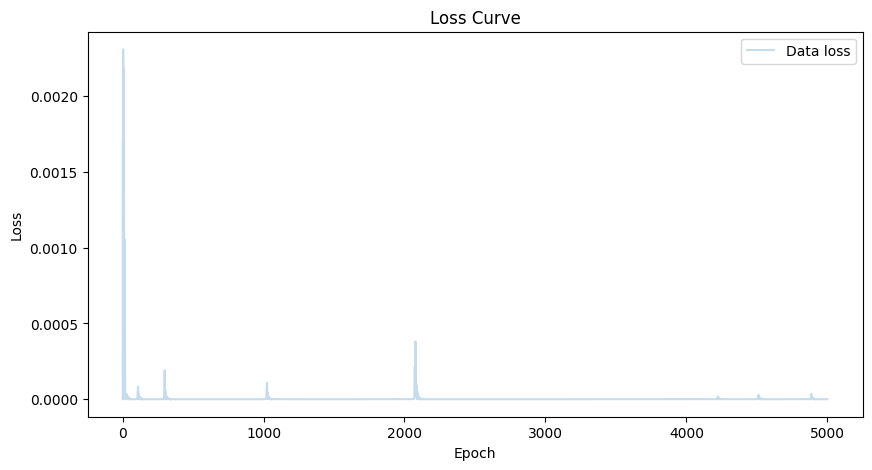

In [140]:
plot_loss_curves(loss_tuple=train_loss_list)

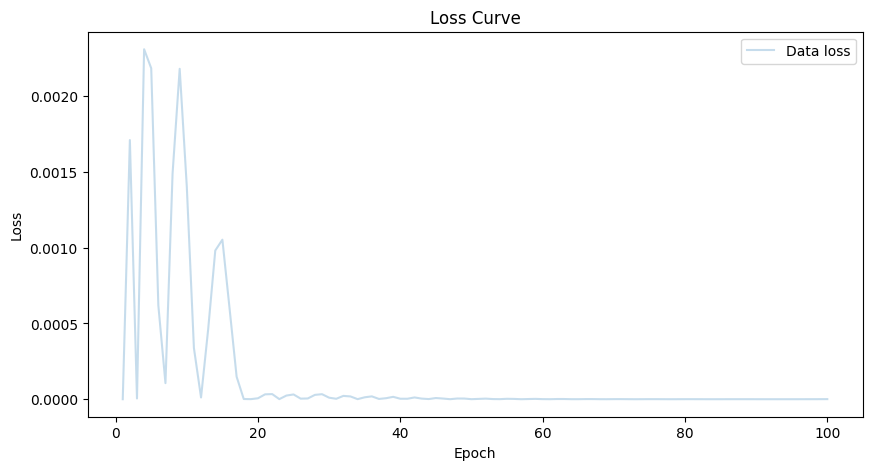

In [141]:
plot_loss_curves(loss_tuple=train_loss_list[0:100])

In [142]:
print(pred_history_list[0].cpu().detach().numpy())

[-1.09256804e-03 -3.86551023e-04 -9.59634781e-06  2.76267529e-05
  5.02020121e-05  6.37769699e-05  7.17043877e-05  7.58320093e-05
  7.76350498e-05  7.75158405e-05  7.65621662e-05  7.51018524e-05
  7.29411840e-05  7.07060099e-05  6.82920218e-05  6.59078360e-05
  6.36130571e-05  6.10798597e-05  5.87403774e-05  5.65052032e-05
  5.44041395e-05  5.23328781e-05  5.02914190e-05  4.84585762e-05
  4.66704369e-05  4.48375940e-05  4.32878733e-05  4.16785479e-05
  4.03970480e-05  3.88324261e-05  3.74615192e-05  3.62694263e-05
  3.49879265e-05  3.39150429e-05  3.26633453e-05  3.16351652e-05
  3.06516886e-05  2.97427177e-05  2.87443399e-05  2.78800726e-05
  2.68667936e-05  2.61664391e-05  2.52872705e-05  2.45720148e-05
  2.39163637e-05  2.31862068e-05  2.24858522e-05  2.18600035e-05
  2.13235617e-05  2.07573175e-05  2.01165676e-05  1.94907188e-05
  1.88797712e-05  1.84178352e-05  1.80453062e-05  1.75237656e-05
  1.70767307e-05  1.66296959e-05  1.60932541e-05  1.56760216e-05
  1.53034925e-05  1.49607

In [143]:
print(data_y_np)

[ 0.00000e+00 -2.86431e-11 -1.14185e-10 -2.56046e-10 -4.53645e-10
 -7.06401e-10 -1.01373e-09 -1.37506e-09 -1.78981e-09 -2.25739e-09
 -2.77722e-09 -3.34873e-09 -3.97133e-09 -4.64444e-09 -5.36749e-09
 -6.13988e-09 -6.96105e-09 -7.83041e-09 -8.74737e-09 -9.71137e-09
 -1.07218e-08 -1.17781e-08 -1.28797e-08 -1.40260e-08 -1.52165e-08
 -1.64504e-08 -1.77274e-08 -1.90467e-08 -2.04078e-08 -2.18102e-08
 -2.32532e-08 -2.47362e-08 -2.62588e-08 -2.78202e-08 -2.94200e-08
 -3.10575e-08 -3.27321e-08 -3.44433e-08 -3.61906e-08 -3.79732e-08
 -3.97907e-08 -4.16424e-08 -4.35279e-08 -4.54464e-08 -4.73974e-08
 -4.93803e-08 -5.13947e-08 -5.34397e-08 -5.55150e-08 -5.76199e-08
 -5.97538e-08 -6.19162e-08 -6.41064e-08 -6.63239e-08 -6.85681e-08
 -7.08385e-08 -7.31344e-08 -7.54553e-08 -7.78005e-08 -8.01696e-08
 -8.25618e-08 -8.49768e-08 -8.74138e-08 -8.98722e-08 -9.23516e-08
 -9.48513e-08 -9.73707e-08 -9.99093e-08 -1.02466e-07 -1.05042e-07
 -1.07634e-07 -1.10244e-07 -1.12869e-07 -1.15511e-07 -1.18167e-07
 -1.20838e

In [144]:
def plot_prediction(prediction, data_y_np, title='Prediction comparison',length=1, num_nodes=100):
  ''' function to plot the prediction curve
  '''
  # Creating the plot
  fig, ax = plt.subplots(figsize=(10,5))

  beam_length = np.linspace(0, length, num_nodes)

  # Plotting the prediction curve
  ax.plot(beam_length, prediction, linestyle='-', label='Prediction')
  # Plotting true curve
  ax.plot(beam_length, data_y_np, linestyle='-', label='True')


  # Adding title and labels
  ax.set_title('Prediction comparison')
  ax.set_xlabel('Length')
  ax.set_ylabel('Deflection')

  # Adding a legend
  ax.legend()

  # Displaying the plot
  plt.show()

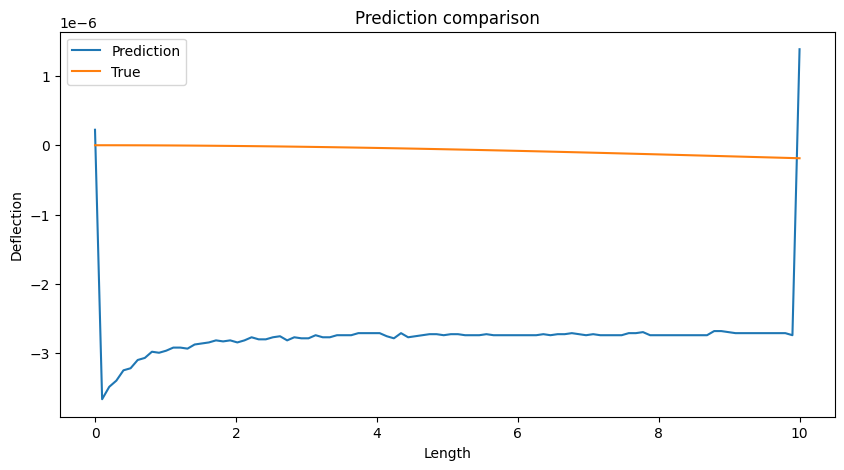

In [145]:
plot_prediction(prediction=pred_history_list[-1].cpu().detach().numpy(),
                data_y_np=data_y_np,
                title='Prediction comparison (only data loss)',
                length=10)